<a href="https://colab.research.google.com/github/LauraJDiaz/Ciencia-De-Datos/blob/main/AnalsisVeroLuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels
!pip install wquantiles

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from statsmodels import robust
import seaborn as sns
import wquantiles
import matplotlib.pyplot as plt
import os
from math import pi
from scipy.stats import f
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Verodatos.xlsx'
df = pd.read_excel(file_path)



Mounted at /content/drive


#  Descripción de variables del dataset de League of Legends

## Información general del juego
- `date`: Fecha de la partida (formato timestamp).
- `region`: Región del servidor (ej. LAN, NA, EUW).
- `game_id`: Identificador único del juego.
- `game_name`: Nombre de la partida.
- `game_type`: Tipo de juego (ej. MATCHED_GAME).
- `game_version`: Versión del juego usada en la partida.
- `game_creation`: Timestamp de creación de la partida.
- `game_duration`: Duración total de la partida (en segundos).
- `platform_id`: Plataforma del servidor (ej. LA1).
- `map_id`: ID del mapa usado (generalmente 11 = Grieta del Invocador).
- `queue_id`: Código de la cola (ej. 420 = SoloQ Ranked).

## Información del jugador
- `champion`: Campeón jugado por el jugador.
- `win`: Resultado de la partida (1 = victoria, 0 = derrota).
- `team_position`: Posición jugada (ej. TOP, JUNGLE, MIDDLE).
- `lane`: Línea principal (TOP, MID, JUNGLE, BOT).
- `role`: Rol asignado en el equipo (SOLO, DUO, CARRY, SUPPORT).
- `level`: Nivel alcanzado al final de la partida.
- `summoner_spells`: Lista de IDs de los hechizos de invocador usados.
- `participants`: Información de los participantes del juego (puede incluir los 10 jugadores).

## Rendimiento del jugador
- `kills`: Asesinatos hechos por el jugador.
- `deaths`: Veces que el jugador murió.
- `assists`: Asistencias a asesinatos.
- `kda`: Ratio KDA = (Kills + Assists) / Deaths.
- `cs`: Cantidad de súbditos asesinados (Creep Score).
- `gold_earned`: Oro ganado.
- `gold_spent`: Oro gastado.
- `vision_score`: Puntaje de visión (control del mapa).
- `vision_wards_bought_in_game`: Centinelas de visión comprados.
- `wards_placed`: Centinelas colocados.
- `wards_destroyed`: Centinelas enemigos destruidos.
- `total_minions_killed`: Total de súbditos eliminados.

## Daño e impacto en combate
- `total_damage_dealt`: Daño total hecho.
- `damage_to_champs`: Daño hecho a campeones enemigos.
- `damage_taken`: Daño total recibido.
- `total_damage_taken`: Igual que `damage_taken`.
- `magic_damage_dealt`: Daño mágico infligido.
- `physical_damage_dealt`: Daño físico infligido.
- `true_damage_dealt`: Daño verdadero infligido.
- `timeCCingOthers`: Tiempo total de control de masas sobre enemigos (en segundos).
- `total_units_healed`: Cantidad total de unidades curadas.

## Jugadas destacadas
- `largest_killing_spree`: Mayor racha de asesinatos sin morir.
- `largest_multi_kill`: Mayor número de kills seguidas (doble, triple...).
- `killing_sprees`: Número de rachas de asesinatos logradas.
- `longest_time_spent_living`: Mayor tiempo vivo sin morir.
- `totalTimeSpentDead`: Tiempo total muerto durante la partida (en segundos).

## Objetivos del equipo
- `dragons_killed`: Número de dragones matados por el equipo del jugador.
- `barons_killed`: Barones matados por el equipo del jugador.
- `turret_kills`: Torres destruidas por el jugador.

## Ítems y configuraciones
- `item_1 al item_7`: Items comprados por eljugador.
- `perks`: Conjunto de runas o perks seleccionadas (en formato de lista o string).


#Limpieza de Datos

In [ ]:
df[['Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7']] = \
    df['items'].str.split(',', n=6, expand=True)

# Si los separadores son otro carácter (por ejemplo '|', espacio, etc.), cambia el separador:
# .str.split('|', n=6, expand=True)  # si es barra
# .str.split(' ', n=6, expand=True)  # si es espacio

# Limpia espacios extra (opcional)
for i in range(1, 8):
    df[f'Item{i}'] = df[f'Item{i}'].str.strip()

In [ ]:
# Convertir 'win' de True/False a 1/0
df['win'] = df['win'].astype(int)


# Separar los items en columnas item_1 a item_7
items_df = df['items'].apply(pd.Series)
items_df.columns = [f'item_{i+1}' for i in range(items_df.shape[1])]
df = pd.concat([df.drop(columns=['items']), items_df], axis=1)

#Convertir columnas numéricas a enteros si es posible
for col in df.columns:
    if df[col].dtype == float and df[col].dropna().apply(float.is_integer).all():
        df[col] = df[col].astype('Int64')  # Soporta valores nulos

# Eliminar columnas que no aportan al análisis
columnas_inutiles = ['puuid', 'summoner_id', 'summoner_name', 'match_id', 'teams']
df = df.drop(columns=columnas_inutiles, errors='ignore')


#Agregar Codigo al campeon
le = LabelEncoder()

# Transformar la columna 'champion'
df['champion_code'] = le.fit_transform(df['champion'])


In [ ]:
df_ranked = df[df['queue_id'].isin([420,440])].copy()

print(f"Total de partidas ranked: {df_ranked.shape[0]}")


Total de partidas ranked: 91


#Analisis General

<ipython-input-10-4d6dd847ed3c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=conteo.index, y=conteo.values, palette=colors)


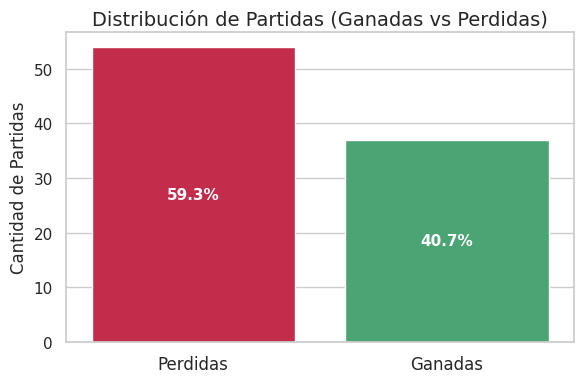

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))

conteo = df_ranked['win'].value_counts().sort_index()
porcentaje = conteo / conteo.sum() * 100

#
colors = ['#DC143C', '#3CB371']  # Rojo para derrotas, verde agua para victorias
bars = sns.barplot(x=conteo.index, y=conteo.values, palette=colors)

# Etiquetas
plt.title("Distribución de Partidas (Ganadas vs Perdidas)", fontsize=14)
plt.xticks([0, 1], ['Perdidas', 'Ganadas'], fontsize=12)
plt.ylabel("Cantidad de Partidas", fontsize=12)
plt.xlabel("")
for i, (val, pct) in enumerate(zip(conteo.values, porcentaje)):
    bars.text(i, val / 2, f"{pct:.1f}%", ha='center', va='center', fontsize=11, fontweight='bold', color='white')

plt.tight_layout()
plt.show()

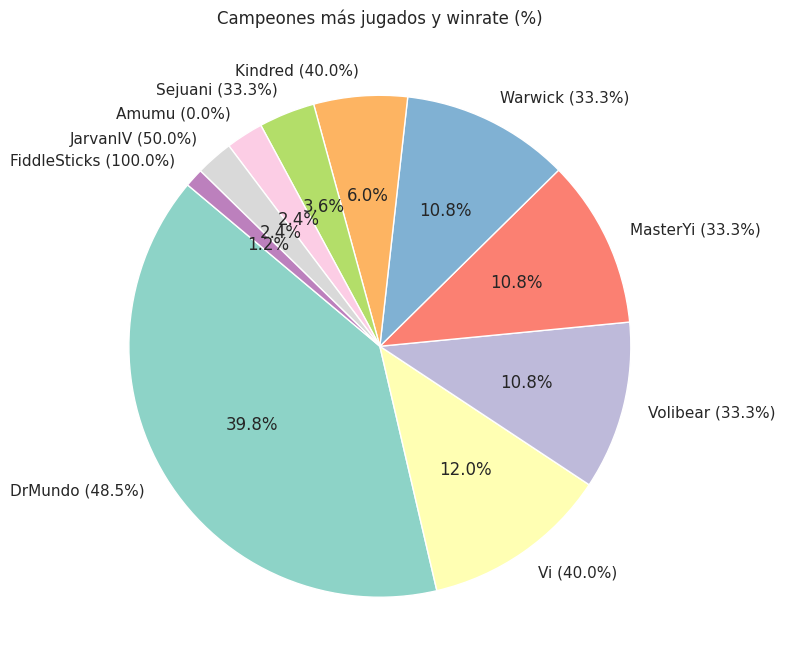

In [ ]:
campeones = df_ranked.groupby('champion').agg(
    partidas=('win', 'count'),
    winrate=('win', 'mean')
).reset_index()


campeones = campeones.sort_values('partidas', ascending=False)


campeones_top = campeones.head(10).copy()


campeones_top['label'] = campeones_top.apply(
    lambda row: f"{row['champion']} ({row['winrate']*100:.1f}%)", axis=1
)

plt.figure(figsize=(8, 8))
colors = plt.cm.Set3.colors
plt.pie(
    campeones_top['partidas'],
    labels=campeones_top['label'],
    autopct=lambda pct: f"{pct:.1f}%",
    startangle=140,
    colors=colors
)
plt.title('Campeones más jugados y winrate (%)')
plt.tight_layout()
plt.show()


In [ ]:
df_mundo = df[df['champion'].isin(['DrMundo'])].copy()

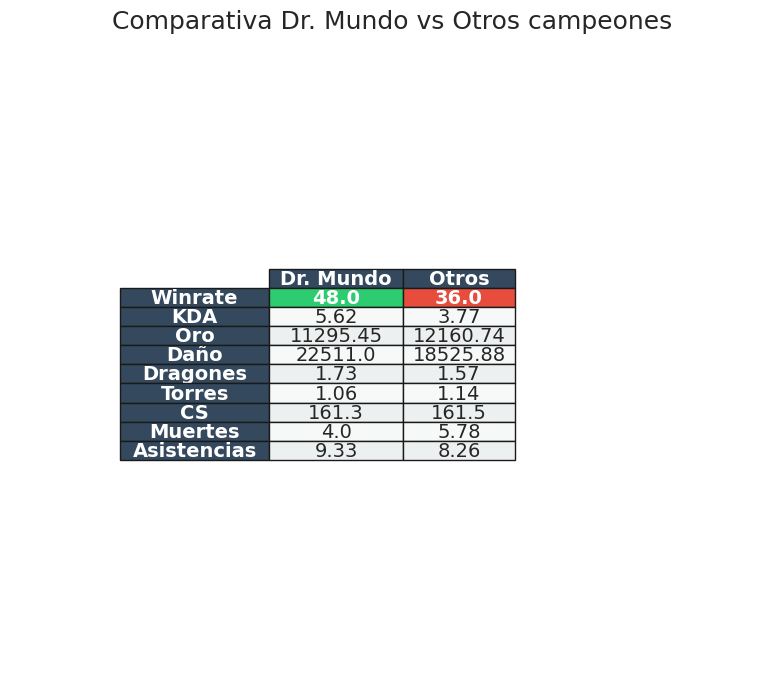

In [ ]:

stats = {
    'win': 'Winrate',
    'kda': 'KDA',
    'gold_earned': 'Oro',
    'damage_to_champs': 'Daño',
    'dragons_killed': 'Dragones',
    'turret_kills': 'Torres',
    'cs': 'CS',
    'deaths': 'Muertes',
    'assists': 'Asistencias'
}

tabla_mundo = df_ranked.groupby('is_mundo')[
    list(stats.keys())
].mean().round(2).T


tabla_mundo.index = [stats[x] for x in tabla_mundo.index]
tabla_mundo.loc['Winrate'] = (tabla_mundo.loc['Winrate'] * 100).round(1)


header_color = '#34495e'
row_colors = ['#f7f9f9', '#ecf0f1'] * (len(tabla_mundo))
highlight_color = '#2ecc71'
lowlight_color = '#e74c3c'

col_win = list(tabla_mundo.columns).index('Dr. Mundo')
max_win = tabla_mundo.loc['Winrate'].max()
min_win = tabla_mundo.loc['Winrate'].min()



fig, ax = plt.subplots(figsize=(8, 7))
ax.axis('off')

tabla_fig = ax.table(
    cellText=tabla_mundo.values,
    colLabels=tabla_mundo.columns,
    rowLabels=tabla_mundo.index,
    loc='center',
    cellLoc='center',
    rowLoc='center'
)

tabla_fig.auto_set_font_size(False)
tabla_fig.set_fontsize(14)
tabla_fig.auto_set_column_width(col=list(range(len(tabla_mundo.columns)+1)))

# Encabezados en blanco con fondo oscuro
for key, cell in tabla_fig.get_celld().items():
    # Encabezados de columnas y filas
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor(header_color)
    # Alterna colores en las filas de datos
    elif key[0] > 0:
        cell.set_facecolor(row_colors[key[0] % 2])

# Resalta el winrate mayor y menor
for j, col in enumerate(tabla_mundo.columns):
    fila_win = list(tabla_mundo.index).index('Winrate') + 1  # +1 por encabezado
    cell = tabla_fig[fila_win, j]
    valor = float(tabla_mundo.loc['Winrate', col])
    if valor == max_win:
        cell.set_facecolor(highlight_color)
        cell.set_text_props(color='white', weight='bold')
    elif valor == min_win:
        cell.set_facecolor(lowlight_color)
        cell.set_text_props(color='white', weight='bold')

plt.title('Comparativa Dr. Mundo vs Otros campeones', pad=20, fontsize=18)
plt.tight_layout()
plt.show()


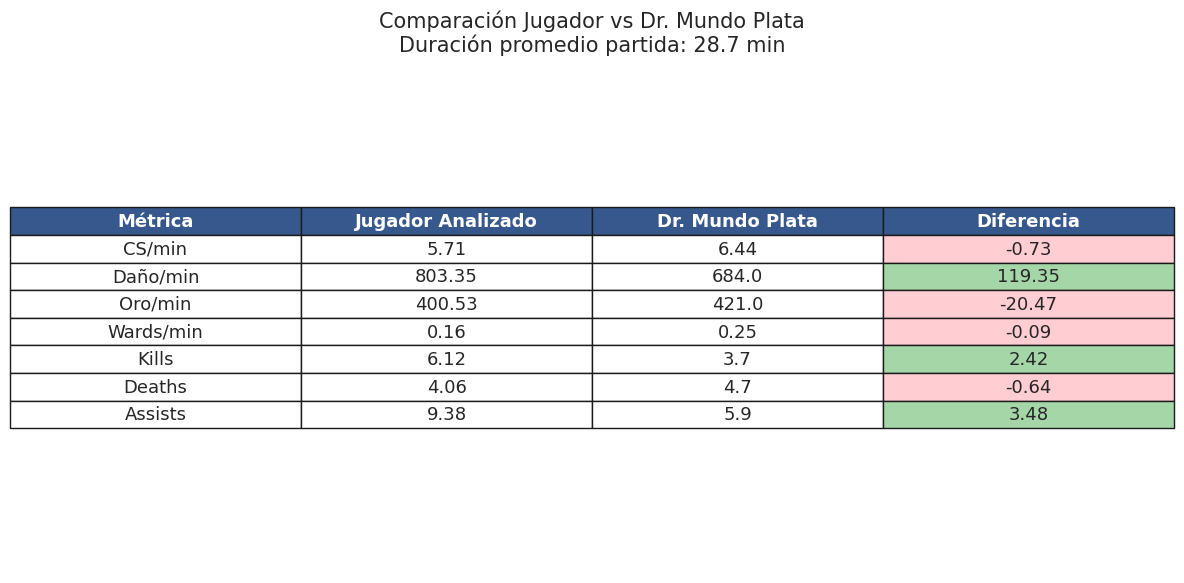

In [ ]:
plata_stats = {
    'CS/min': 6.44,
    'Daño/min': 684,
    'Oro/min': 421,
    'Wards/min': 0.25,
    'Kills': 3.7,    # (Kills, Deaths, Assists) del KDA, saca el valor de la web si quieres
    'Deaths': 4.7,
    'Assists': 5.9
}

df = df_mundo


game_duration = df['game_duration'].mean()
duracion_min = game_duration if game_duration < 100 else game_duration / 60  # Ajusta si tu duración está en seg/min

jugador_stats = {
    'CS/min': df['cs'].mean() / duracion_min,
    'Daño/min': df['damage_to_champs'].mean() / duracion_min,
    'Oro/min': df['gold_earned'].mean() / duracion_min,
    'Wards/min': df['wards_placed'].mean() / duracion_min,
    'Kills': df['kills'].mean(),
    'Deaths': df['deaths'].mean(),
    'Assists': df['assists'].mean()
}

# --- TABLA DE COMPARACIÓN ---
comparacion = pd.DataFrame({
    'Métrica': ['CS/min', 'Daño/min', 'Oro/min', 'Wards/min', 'Kills', 'Deaths', 'Assists'],
    'Jugador Analizado': [
        jugador_stats['CS/min'],
        jugador_stats['Daño/min'],
        jugador_stats['Oro/min'],
        jugador_stats['Wards/min'],
        jugador_stats['Kills'],
        jugador_stats['Deaths'],
        jugador_stats['Assists']
    ],
    'Dr. Mundo Plata': [
        plata_stats['CS/min'],
        plata_stats['Daño/min'],
        plata_stats['Oro/min'],
        plata_stats['Wards/min'],
        plata_stats['Kills'],
        plata_stats['Deaths'],
        plata_stats['Assists']
    ]
})

comparacion['Diferencia'] = comparacion['Jugador Analizado'] - comparacion['Dr. Mundo Plata']

# --- GRÁFICO-TABLA VISUAL ---
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.axis('off')

tabla = ax.table(
    cellText=comparacion.round(2).values,
    colLabels=comparacion.columns,
    loc='center',
    cellLoc='center'
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(13)
tabla.scale(1, 1.5)

# Colores bonitos: encabezado azul, diferencia verde/rojo
for (i, j), cell in tabla.get_celld().items():
    if i == 0:
        cell.set_facecolor('#36588c')
        cell.set_text_props(color='white', weight='bold')
    elif j == 3:  # Columna diferencia
        valor = float(cell.get_text().get_text())
        cell.set_facecolor('#a5d6a7' if valor >= 0 else '#ffcdd2')

plt.title(f'Comparación Jugador vs Dr. Mundo Plata\nDuración promedio partida: {duracion_min:.1f} min',
          pad=8, fontsize=15)

plt.tight_layout()
plt.show()


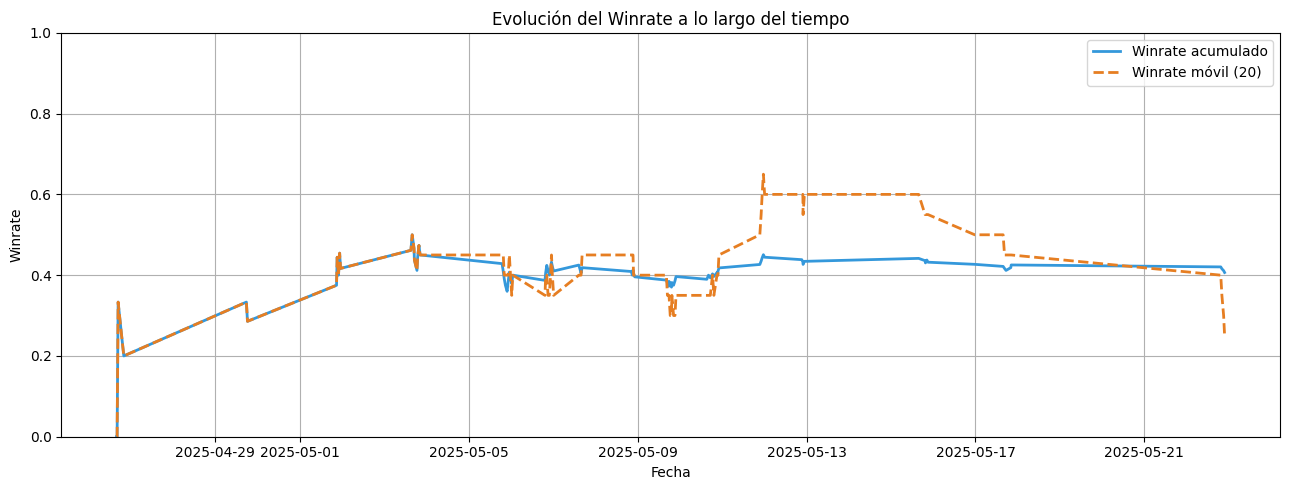

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df_ranked['date_dt'] = pd.to_datetime(df_ranked['date'], unit='ms')


df_ranked = df_ranked.sort_values('date_dt').reset_index(drop=True)


df_ranked['Winrate_acumulado'] = df_ranked['win'].expanding().mean()


window = 20
df_ranked['Winrate_rolling'] = df_ranked['win'].rolling(window, min_periods=1).mean()

plt.figure(figsize=(13, 5))
plt.plot(df_ranked['date_dt'], df_ranked['Winrate_acumulado'], color='#3498db', linewidth=2, label='Winrate acumulado')
plt.plot(df_ranked['date_dt'], df_ranked['Winrate_rolling'], color='#e67e22', linestyle='--', linewidth=2, label=f'Winrate móvil ({window})')
plt.title('Evolución del Winrate a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Winrate')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


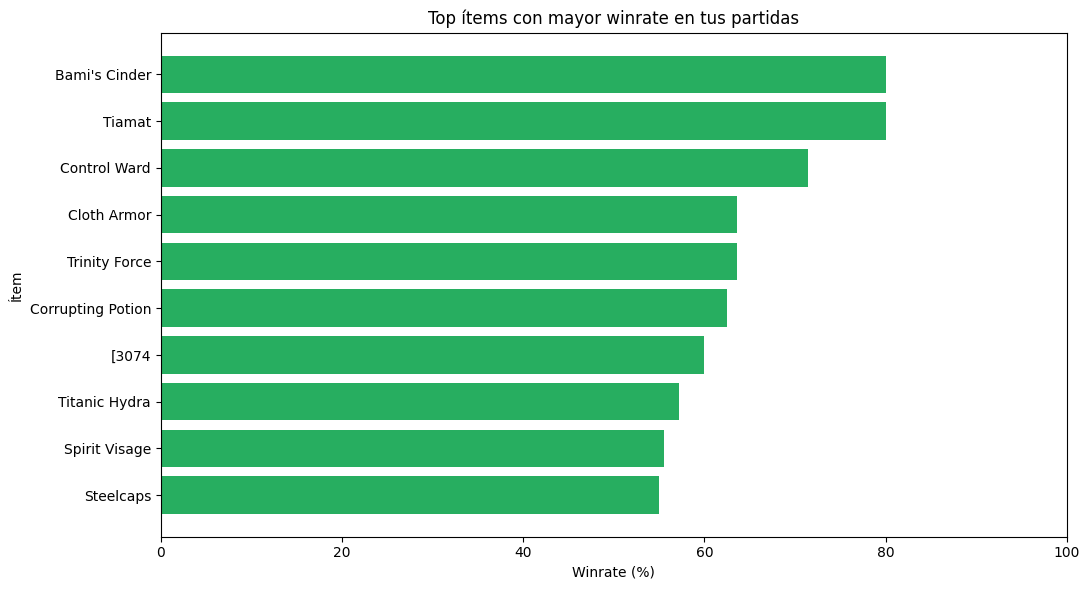

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


item_dict = {
    '3077': 'Tiamat',
    '2501': "Bami's Cinder",
    '2055': 'Control Ward',
    '1029': 'Cloth Armor',
    '3078': 'Trinity Force',
    '2021': 'Corrupting Potion',
    '3074': 'Ravenous Hydra',
    '3748': 'Titanic Hydra',
    '3065': 'Spirit Visage',
    '3047': 'Steelcaps'
}

items_cols = [f'Item{i}' for i in range(1, 8)]
df_items = df_ranked.melt(
    id_vars=['win'], value_vars=items_cols,
    var_name='item_slot', value_name='item'
)
df_items = df_items.dropna()
df_items = df_items[df_items['item'] != '']

df_items['item_name'] = df_items['item'].map(item_dict)
df_items['item_name'] = df_items['item_name'].fillna(df_items['item'])

uso_minimo = 5
winrate_items = df_items.groupby('item_name').agg(
    partidas=('win', 'count'),
    winrate=('win', 'mean')
).query('partidas >= @uso_minimo').sort_values('winrate', ascending=False)

top = 10
plt.figure(figsize=(11, 6))
plt.barh(
    winrate_items.head(top).index[::-1],
    winrate_items.head(top)['winrate'][::-1]*100,
    color='#27ae60'
)
plt.xlabel('Winrate (%)')
plt.ylabel('Ítem')
plt.title('Top ítems con mayor winrate en tus partidas')
plt.xlim(0, 100)
plt.tight_layout()
plt.show()


#Anova y Variables Correlacionadas

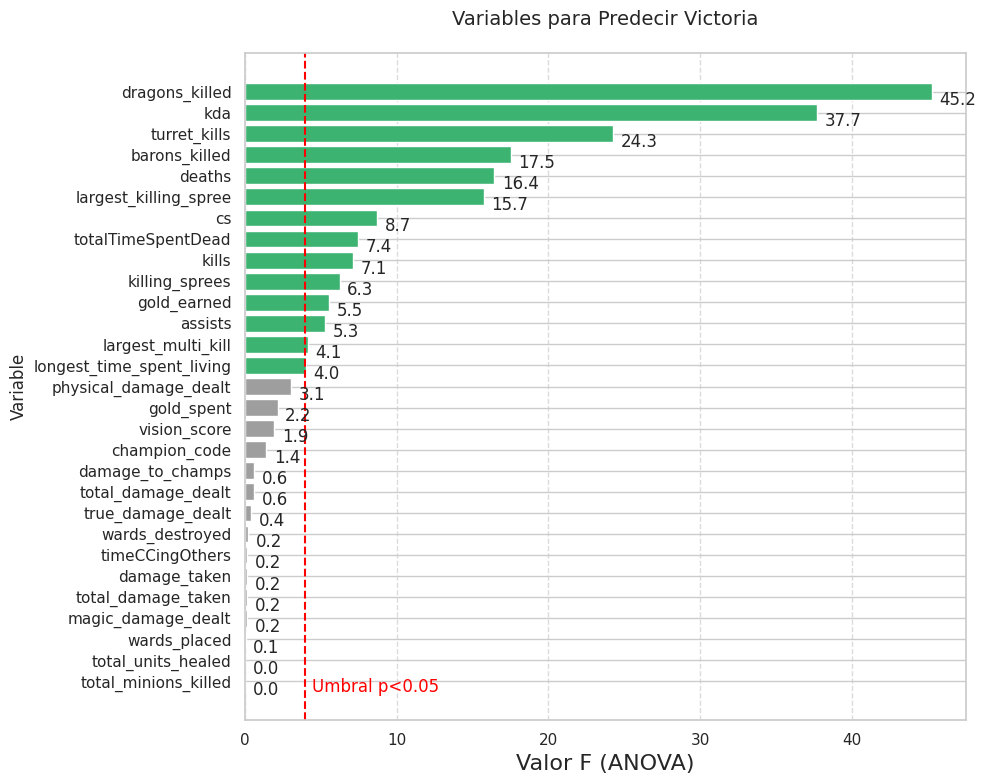

In [ ]:
from scipy import stats

f_values = []
p_values = []
variables = ['champion_code', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'magic_damage_dealt',
       'physical_damage_dealt', 'true_damage_dealt', 'timeCCingOthers',
       'total_minions_killed', 'largest_killing_spree', 'largest_multi_kill',
       'killing_sprees', 'longest_time_spent_living',
       'total_units_healed', 'totalTimeSpentDead','damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed']


#Anova
for var in variables:
    group1 = df_ranked[df_ranked['win'] == 1][var]
    group0 = df_ranked[df_ranked['win'] == 0][var]
    f_val, p_val = stats.f_oneway(group1, group0)
    f_values.append(f_val)
    p_values.append(p_val)

anova_results = pd.DataFrame({
    'Variable': variables,
    'F_value': f_values,
    'p_value': p_values
}).sort_values('F_value', ascending=False)


# Gráfico
plt.figure(figsize=(10, 8))
bars = plt.barh(anova_results['Variable'], anova_results['F_value'],
                color=['#3CB371' if p < 0.05 else '#9E9E9E' for p in anova_results['p_value']])

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height(),
             f'{width:.1f}', ha='left', va='center')

# Línea
max_f = max(f_values) * 1.1
plt.axvline(x=f.ppf(0.95, 1, len(df_ranked)-2), color='red', linestyle='--')
plt.text(f.ppf(0.95, 1, len(df_ranked)-2)+0.5, len(variables)-0.5,
         'Umbral p<0.05', color='red')

plt.xlabel('Valor F (ANOVA)', fontsize=16)
plt.ylabel('Variable', fontsize=12)
plt.title('Variables para Predecir Victoria',
          fontsize=14, pad=20)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

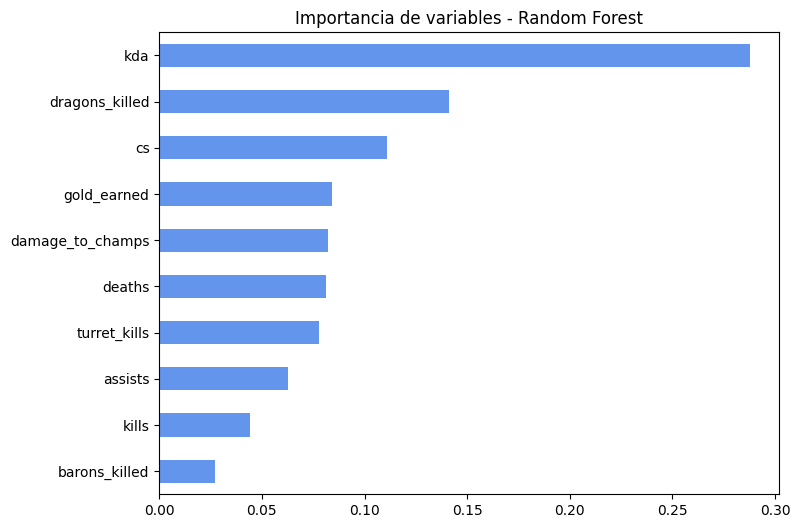

              precision    recall  f1-score   support

     Derrota       0.92      0.92      0.92        13
    Victoria       0.83      0.83      0.83         6

    accuracy                           0.89        19
   macro avg       0.88      0.88      0.88        19
weighted avg       0.89      0.89      0.89        19



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
importances.plot(kind='barh', color='#6495ED')
plt.title("Importancia de variables - Random Forest")
plt.show()

# Precisión
from sklearn.metrics import classification_report
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf, target_names=['Derrota', 'Victoria']))


In [ ]:
anova_variables = [
    'dragons_killed', 'kda', 'turret_kills', 'barons_killed', 'deaths',
    'largest_killing_spree', 'cs', 'totalTimeSpentDead', 'kills', 'killing_sprees'
]


<ipython-input-37-decfc35151de>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
<ipython-input-37-decfc35151de>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Perdidas', 'Ganadas'])
<ipython-input-37-decfc35151de>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
<ipython-input-37-decfc35151de>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axe

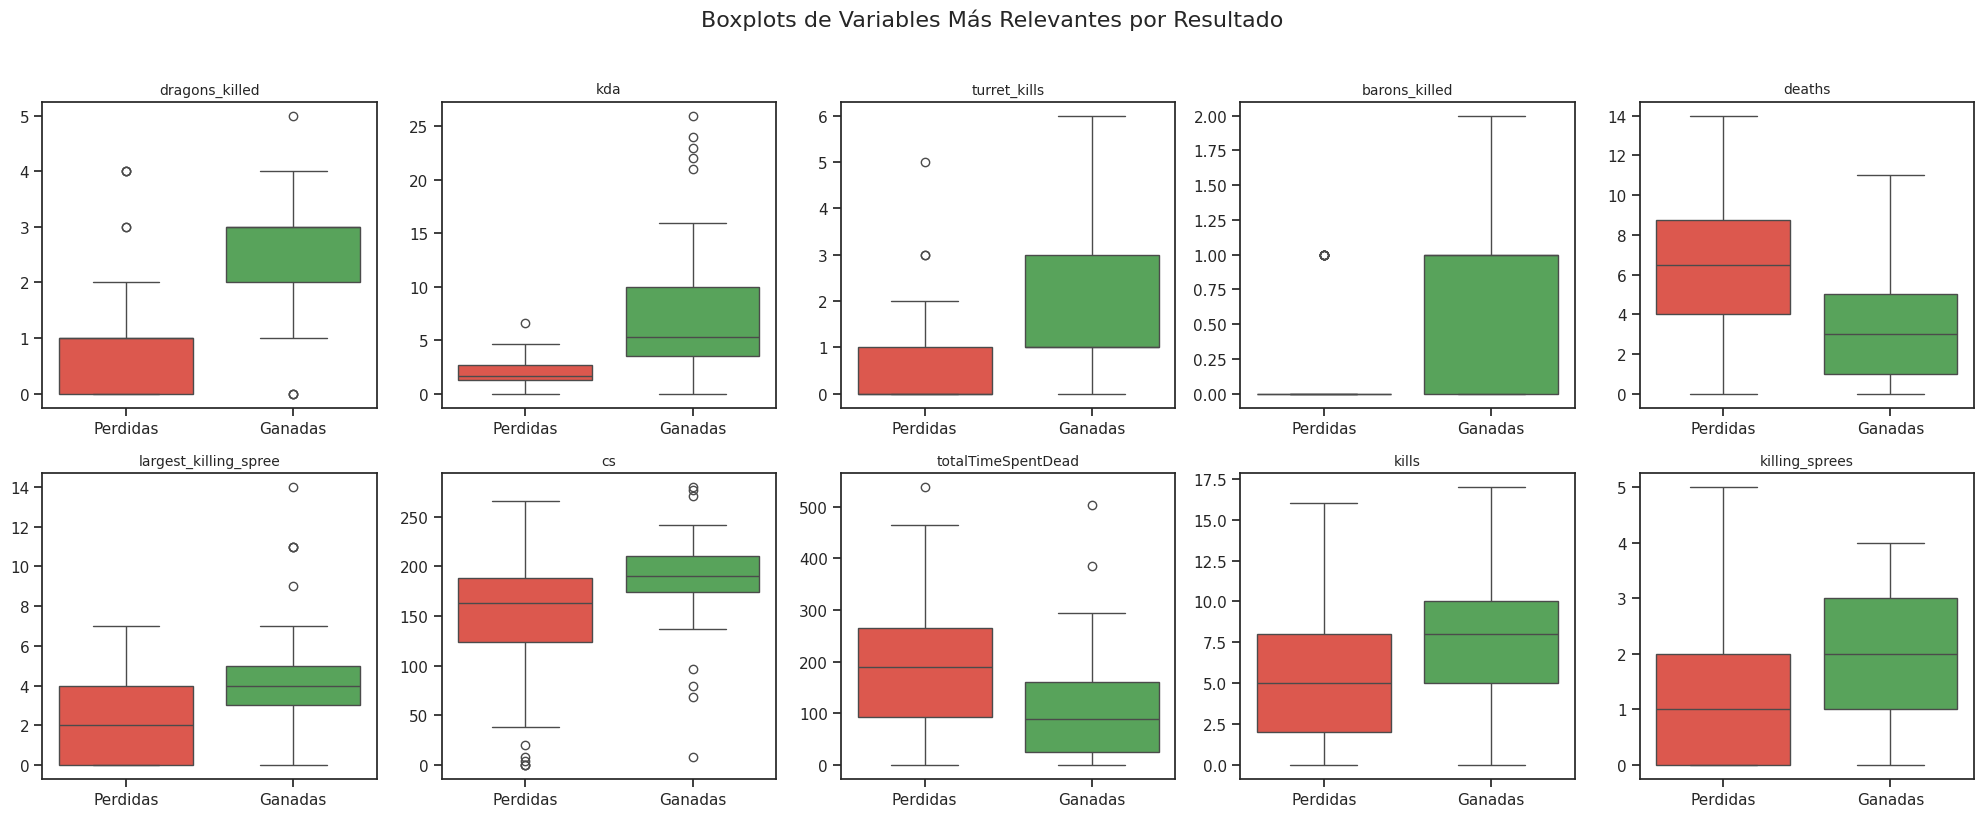

In [ ]:
sns.set(style="ticks", palette="Set2")

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
axes = axes.flatten()  # Convertir en lista

for i, var in enumerate(anova_variables):
    sns.boxplot(data=df_ranked, x='win', y=var, ax=axes[i], palette=['#F44336','#4CAF50', ])
    axes[i].set_title(f'{var}', fontsize=10)
    axes[i].set_xticklabels(['Perdidas', 'Ganadas'])
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar espacio
plt.suptitle("Boxplots de Variables Más Relevantes por Resultado", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

#Grafico Araña

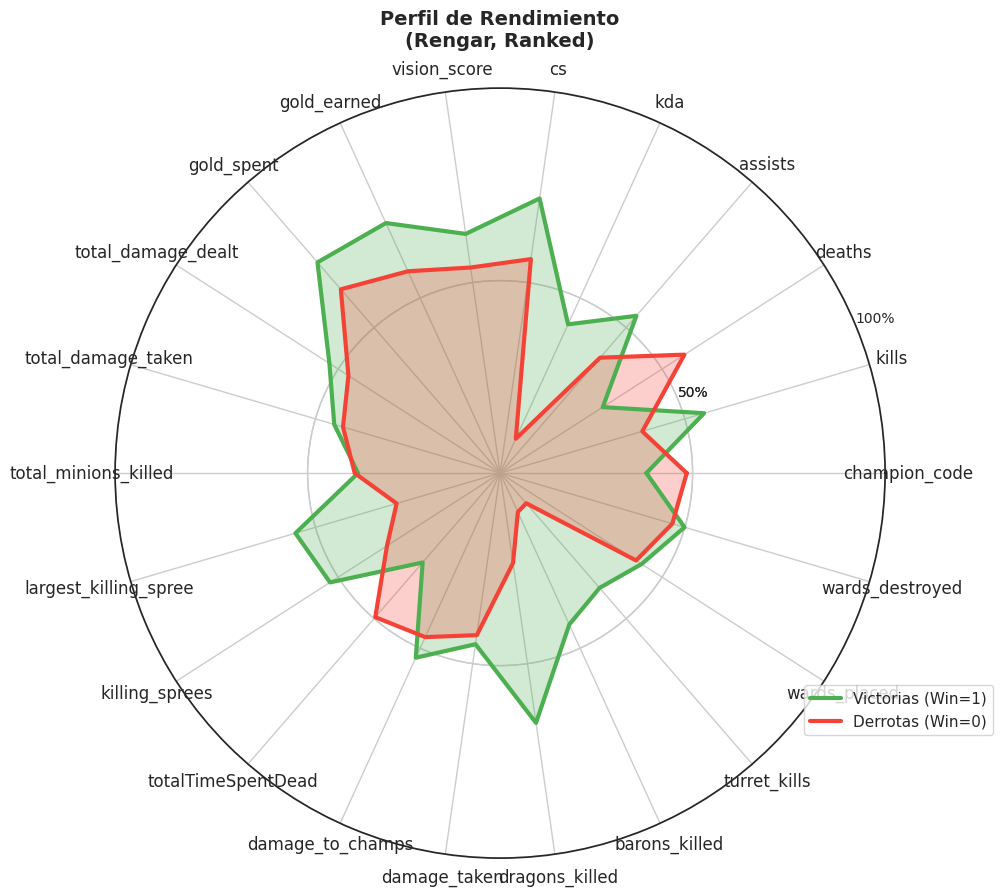

In [ ]:
variables_radar = ['champion_code', 'kills', 'deaths',
       'assists', 'kda', 'cs', 'vision_score', 'gold_earned', 'gold_spent',
       'total_damage_dealt', 'total_damage_taken', 'total_minions_killed', 'largest_killing_spree',
       'killing_sprees', 'totalTimeSpentDead','damage_to_champs', 'damage_taken',
       'dragons_killed', 'barons_killed', 'turret_kills', 'wards_placed',
       'wards_destroyed']

# Percentiles
def normalize_by_percentile(series):
    p95 = np.percentile(series, 95)
    p5 = np.percentile(series, 5)
    return (series - p5) / (p95 - p5)

norm_data = df_ranked[variables_radar + ['win']].copy()
for var in variables_radar:
    norm_data[var] = normalize_by_percentile(norm_data[var])


mean_win1 = norm_data[norm_data['win']==1][variables_radar].mean()
mean_win0 = norm_data[norm_data['win']==0][variables_radar].mean()


categories = variables_radar
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, polar=True)

# Win=1
values = mean_win1.tolist()
values += values[:1]
ax.plot(angles, values, color='#4CAF50', linewidth=3, label='Victorias (Win=1)')
ax.fill(angles, values, color='#4CAF50', alpha=0.25)

# Win=0
values = mean_win0.tolist()
values += values[:1]
ax.plot(angles, values, color='#F44336', linewidth=3, label='Derrotas (Win=0)')
ax.fill(angles, values, color='#F44336', alpha=0.25)

plt.xticks(angles[:-1], categories, fontsize=12)
plt.yticks([0.5, 0.5, 1], ['0%', '50%', '100%'], fontsize=10)
plt.ylim(0, 1)

# Título y leyenda
plt.title('Perfil de Rendimiento\n(Rengar, Ranked)',
          pad=30, fontsize=14, fontweight='bold')
plt.legend(loc='lower right', bbox_to_anchor=(1.15, 0.15))


plt.show()

#Arbol

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

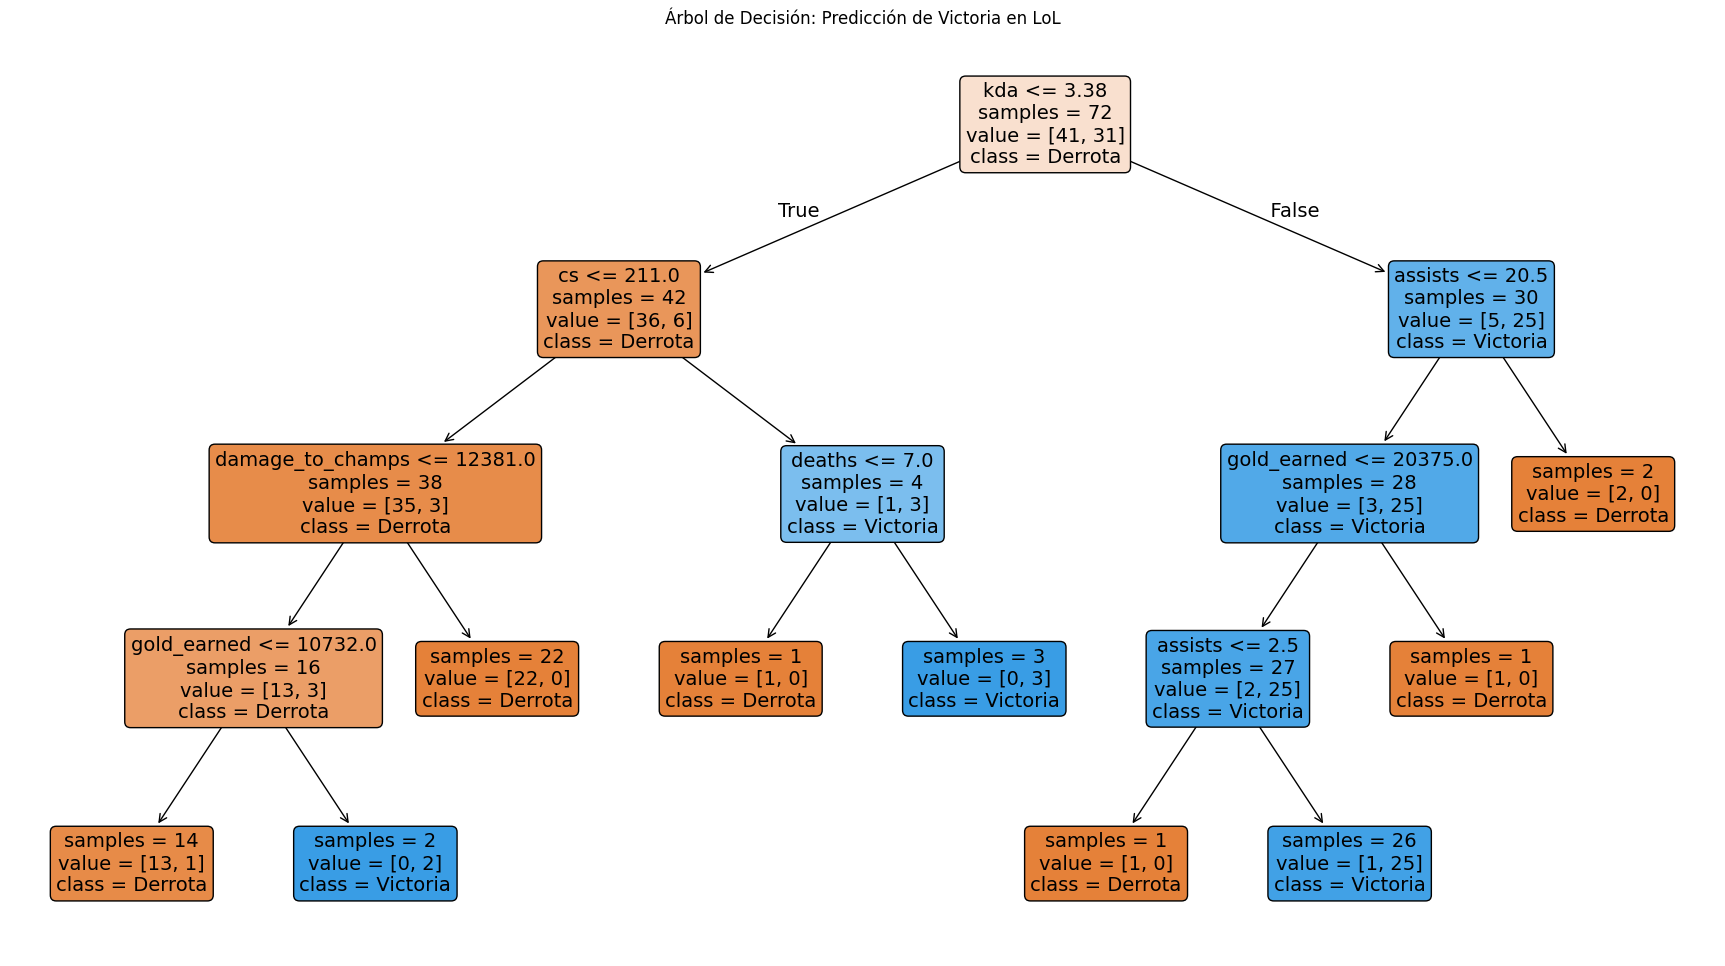

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(22, 12))
plot_tree(
    modelo,
    feature_names=features,
    class_names=["Derrota", "Victoria"],
    filled=True,
    rounded=True,
    impurity=False,
    fontsize=14
)
plt.title("Árbol de Decisión: Predicción de Victoria en LoL")
plt.savefig("arbol_lol_colores.png", bbox_inches='tight')
plt.show()



In [ ]:
from sklearn.metrics import classification_report

y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Derrota', 'Victoria']))


              precision    recall  f1-score   support

     Derrota       0.92      0.92      0.92        13
    Victoria       0.83      0.83      0.83         6

    accuracy                           0.89        19
   macro avg       0.88      0.88      0.88        19
weighted avg       0.89      0.89      0.89        19



#Cluster

            kills    deaths    assists       kda          cs   gold_earned  \
cluster                                                                      
0        9.700000  4.166667  13.066667  8.629667  207.966667  15600.200000   
1        5.977273  7.227273   8.363636  2.488182  172.272727  12560.500000   
2        1.352941  1.411765   1.588235  2.107647   51.235294   3376.764706   

         damage_to_champs  dragons_killed  barons_killed  turret_kills  \
cluster                                                                  
0            31602.066667        2.900000       0.833333      2.166667   
1            18637.613636        1.272727       0.181818      0.795455   
2             2896.882353        0.294118       0.000000      0.058824   

         vision_score       win  
cluster                          
0           32.066667  0.766667  
1           26.795455  0.227273  
2            4.941176  0.235294  


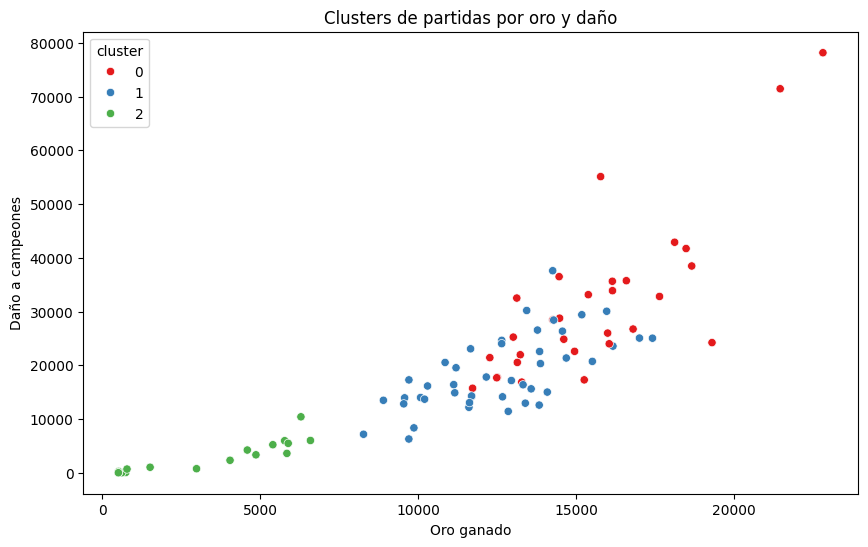

In [ ]:


# Ahora puedes analizar cada cluster
print(df_ranked.groupby('cluster')[features_cluster + ['win']].mean())

# Visualiza los clusters en 2D (usando las 2 variables principales)
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df_ranked['gold_earned'], y=df_ranked['damage_to_champs'],
    hue=df_ranked['cluster'], palette='Set1'
)
plt.title("Clusters de partidas por oro y daño")
plt.xlabel("Oro ganado")
plt.ylabel("Daño a campeones")
plt.show()



In [ ]:

medias_clusters = df_ranked.groupby('cluster')[features_cluster].mean()
print(medias_clusters)


            kills    deaths    assists       kda          cs   gold_earned  \
cluster                                                                      
0        9.700000  4.166667  13.066667  8.629667  207.966667  15600.200000   
1        5.977273  7.227273   8.363636  2.488182  172.272727  12560.500000   
2        1.352941  1.411765   1.588235  2.107647   51.235294   3376.764706   

         damage_to_champs  dragons_killed  barons_killed  turret_kills  \
cluster                                                                  
0            31602.066667        2.900000       0.833333      2.166667   
1            18637.613636        1.272727       0.181818      0.795455   
2             2896.882353        0.294118       0.000000      0.058824   

         vision_score  
cluster                
0           32.066667  
1           26.795455  
2            4.941176  


In [ ]:
cluster_names = {
    0: "Hard Carry",
    1: "Try",
    2: "Low Impact"  # o "Stomp", o "Soporte" si quieres ser generoso, pero los datos sugieren low impact
}

df_ranked['estilo_partida'] = df_ranked['cluster'].map(cluster_names)

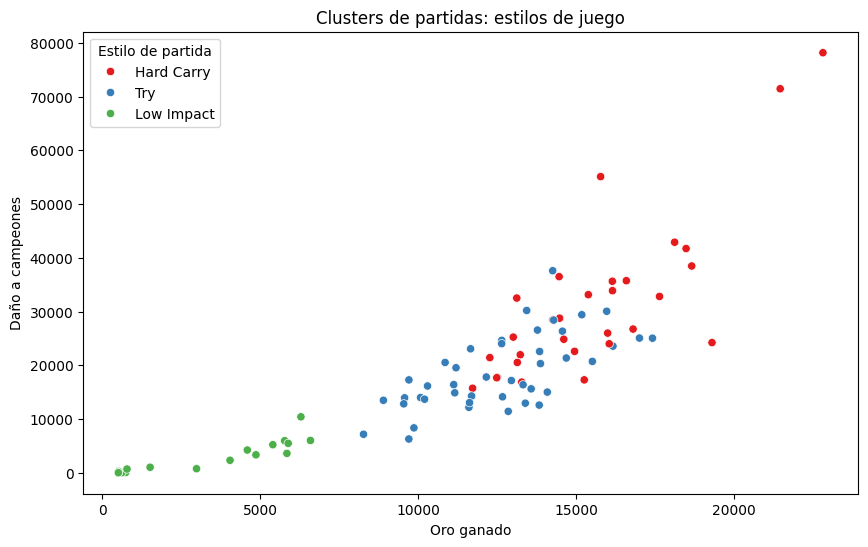

In [ ]:

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='gold_earned', y='damage_to_champs',
    hue='estilo_partida', data=df_ranked, palette='Set1'
)
plt.title("Clusters de partidas: estilos de juego")
plt.xlabel("Oro ganado")
plt.ylabel("Daño a campeones")
plt.legend(title="Estilo de partida")
plt.show()
